# Parsing PGE logs for metrics or why we need SDSWatch

ISCE2 outputs important information such as execution times, processing parameter values, etc. For example:

In [1]:
!tail -23 isce.log

2018-10-10 20:50:18,018 - isce.mroipac.filter - DEBUG - width: 3557
2018-10-10 20:50:18,018 - isce.mroipac.filter - DEBUG - length: 1814
2018-10-10 20:50:18,018 - isce.mroipac.filter - DEBUG - input: merged/topophase.flat
2018-10-10 20:50:18,019 - isce.mroipac.filter - DEBUG - output: merged/filt_topophase.flat
2018-10-10 20:50:18,019 - isce.mroipac.filter - DEBUG - filter strength: 0.5
2018-10-10 20:50:18,019 - isce.mroipac.filter - INFO - Filtering interferogram
2018-10-10 20:57:09,574 - isce.topsinsar.runGeocode - INFO - Geocoding Image
2018-10-10 20:58:02,534 - isce.topsinsar.runGeocode - INFO - 
####################################################################################################
    runGeocode
----------------------------------------------------------------------------------------------------
geocode.Azimuth looks = 7
geocode.Dem Used = demLat_N09_N14_Lon_W068_W064.dem.wgs84.wgs84
geocode.East = -64.19954545454546
geocode.Geocoding:  = merged/filt_topophase.unw.con

A request was made to extract statistics on the execution time of the phase unwrapping stage of the ISCE2 processor. This execution time can be estimated by differencing the timestamps of the following 2 log lines:


```
2018-10-10 20:50:18,019 - isce.mroipac.filter - INFO - Filtering interferogram
2018-10-10 20:57:09,574 - isce.topsinsar.runGeocode - INFO - Geocoding Image
```

In addition, the width and length of the data needs to be extracted as well:

```
2018-10-10 20:50:18,018 - isce.mroipac.filter - DEBUG - width: 3557
2018-10-10 20:50:18,018 - isce.mroipac.filter - DEBUG - length: 1814
```

To do this in post processing, we have to harvest all the `isce.log` files co-located with the published products, parse the log files, and aggregate them into a dataframe.

The following code block shows the extraction of the requested fields along with other potentially useful fields:

In [2]:
import json
from parse_logs import parse

sample_isce_log = "isce.log"

print(json.dumps(parse(sample_isce_log), indent=2))

{
  "id": "",
  "master_asc_node_time": "2018-09-17T20:52:30.569446",
  "slave_asc_node_time": "2018-09-11T22:31:56.843333",
  "filt_start_dt": "2018-10-10T20:50:18.019000",
  "geocoding_start_dt": "2018-10-10T20:57:09.574000",
  "filter_geo_delta_secs": 411,
  "length": 1814,
  "width": 3557,
  "east": -64.19954545454546,
  "west": -66.83081818181819,
  "south": 10.544,
  "north": 12.47409090909091,
  "alks": 7,
  "rlks": 19,
  "lat": 11.509045454545454,
  "lon": -65.51518181818182
}


The `filter_geo_delta_secs` contains the estimated phase unwrapping run time from this ISCE2 run.

We harvested 20K+ `isce.log` files from all interferogram products generated by ARIA/GRFN and generated a CSV file that aggregated the metrics extracted from each file. See the `parse_logs.py` script included in this repository.

Finally we create a dataframe from this CSV:

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gp
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, Choropleth
from ipywidgets import Layout, link, FloatSlider, Label, VBox
import seaborn as sns

csv_file = "isce_log.csv"
df = pd.read_csv(csv_file)

We create a geodataframe to be able to visualize the centroids of each file:

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

We describe the dataset:

In [5]:
gdf.describe()

,filter_geo_delta_secs,length,width,east,west,south,north,alks,rlks,lat,lon
count,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000,22957.000000
mean,743.483251,3386.287625,3056.165832,-126.825980,-128.232936,21.335932,23.052011,6.442784,10.977610,22.193972,-127.529458
std,454.152952,1447.194177,1476.325501,44.892965,44.701921,19.914728,19.880932,7.729258,8.936809,19.897680,44.797140
min,2.000000,289.000000,617.000000,-177.179444,-178.884167,-77.686389,-76.297778,3.000000,7.000000,-76.992083,-178.031806
25%,406.000000,2292.000000,2938.000000,-154.851111,-156.100833,18.244444,19.941667,3.000000,7.000000,19.088889,-155.476389
50%,907.000000,4079.000000,3398.000000,-152.313889,-153.450833,19.708611,21.396111,3.000000,7.000000,20.493056,-152.882222
75%,1102.000000,4082.000000,3514.000000,-114.430556,-115.892778,34.496111,36.298611,3.000000,7.000000,35.410139,-115.192222
max,1984.000000,5870.000000,9914.000000,179.613611,177.646944,64.317494,65.951405,33.000000,33.000000,65.134450,178.598889


There are over 20K records.

We display a heatmap of centroid locations:

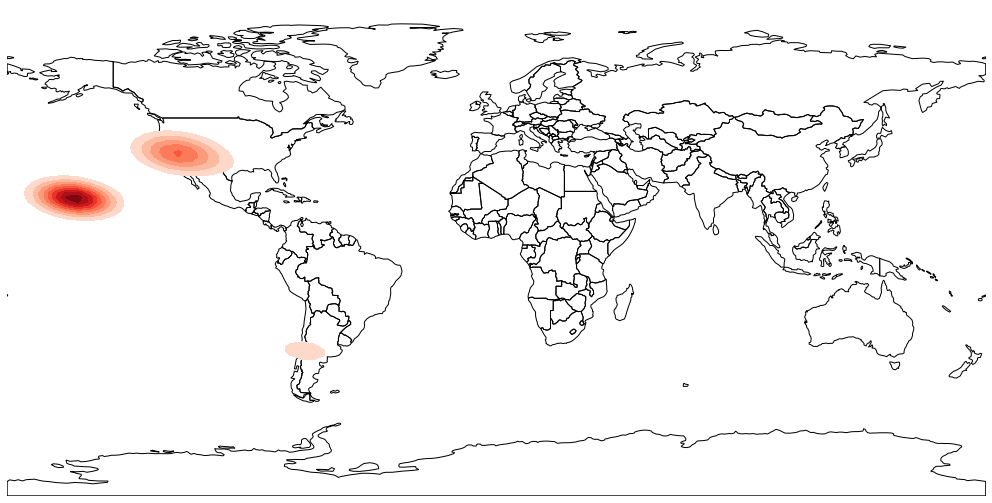

In [6]:
%matplotlib inline

world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
figsize = (18, 9)
ax = gp.kdeplot(gdf, shade=True, cmap='Reds', figsize=figsize)
gp.polyplot(world, ax=ax)

Show the distribution of phase unwrapping runtimes:

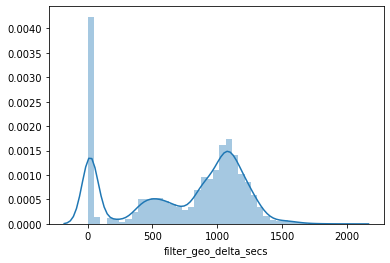

In [7]:
ax = sns.distplot(df["filter_geo_delta_secs"])

and bivariate KDE with respect to data size:

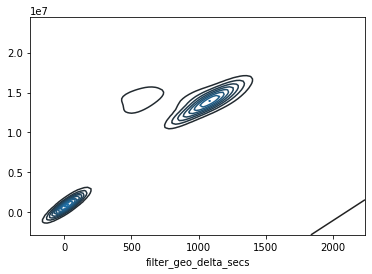

In [8]:
ax = sns.kdeplot(df["filter_geo_delta_secs"], df["length"] * df["width"])